<h2 style="text-align: center; background-color: #4d648d; font-family:Arial; color: white; padding: 13px; line-height: 1; border-radius:10px">Initiation aux séries temporelles 🗓</h2>

In [12]:
# Import des librairies nécessaires 
%matplotlib inline

import pandas as pd # pour la manipulation des données
import numpy as np # pour les calculs sur tableaux de nomnbres
import matplotlib.pyplot as plt # pour les affichages graphiques
import seaborn as sns # pour la data Visualisation

import datetime as dt # pour le traitement de série temporelle
from statsmodels.tsa.seasonal import seasonal_decompose # pour décomposer la série temporelle en tendance saison résidu
from statsmodels.tsa.api import ExponentialSmoothing

from sklearn import linear_model 

# Supppression des warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
conso_elec=pd.read_excel('eCO2mix_RTE_energie_M.xlsx')
conso_elec.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [3]:
conso_elec=conso_elec[['Mois','Consommation totale']][(conso_elec.Territoire=='France')]
conso_elec.columns=(['mois', 'conso_totale'])

In [4]:
def convertir_fin_de_mois(yyyy_mm) :
    if yyyy_mm[5:8]!='12' :
        res=pd.to_datetime(yyyy_mm[0:4]+'-'+str(int(yyyy_mm[5:8])+1), format='%Y-%m')-dt.timedelta(days=1)
    else : 
        res=pd.to_datetime(str(int(yyyy_mm[0:4])+1)+'-'+'01', format='%Y-%m')-dt.timedelta(days=1)                         
    return res

In [5]:
conso_elec.mois=[convertir_fin_de_mois(yyyy_mm) for yyyy_mm in conso_elec.mois]
conso_elec.head()

,mois,conso_totale
0,2012-01-31,51086
1,2012-02-29,54476
2,2012-03-31,43156
3,2012-04-30,40176
4,2012-05-31,35257


In [6]:
conso_elec2 = conso_elec.set_index('mois')
conso_elec2.head()

,conso_totale
mois,
2012-01-31,51086
2012-02-29,54476
2012-03-31,43156
2012-04-30,40176
2012-05-31,35257


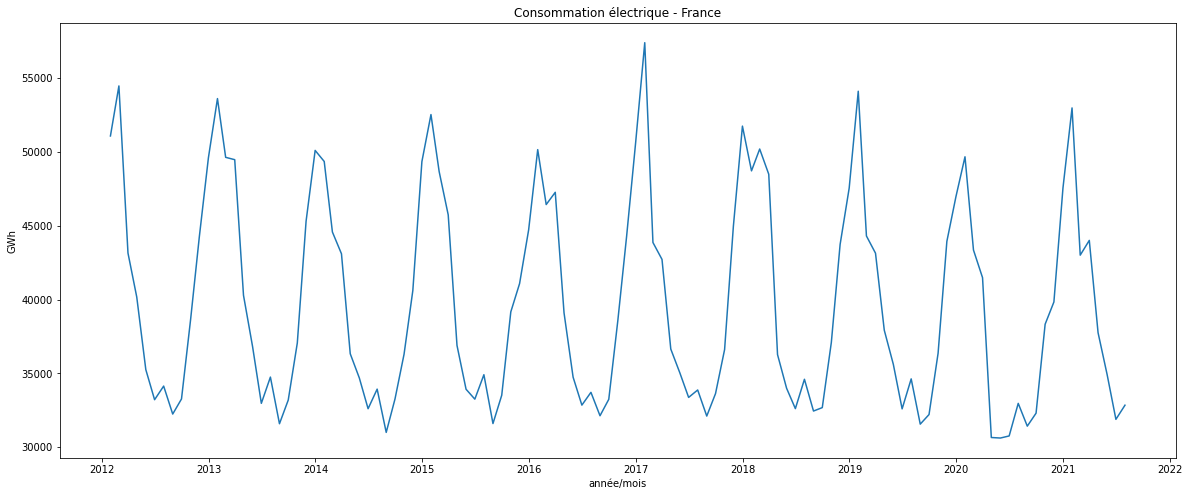

In [7]:
plt.figure(figsize=(20,8))
plt.plot(conso_elec2)
plt.title('Consommation électrique - France')
plt.xlabel('année/mois')
plt.ylabel('GWh')
plt.show()

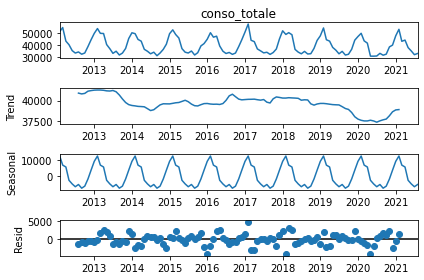

In [8]:
decomp_conso_elec = seasonal_decompose(conso_elec2.conso_totale, model='additive')
decomp_conso_elec.plot()
plt.show()

In [9]:
# Création d'un échantillon d'entrainement
mois_tronqué=12 # Nombre de mois tronqués
echantillon_train=conso_elec2[:-mois_tronqué] # Echantillon d'entrainement = Echantillon étudié - 12 mois

In [10]:
echantillon_test=conso_elec2[(len(conso_elec2)-12):len(conso_elec2)]
echantillon_test

,conso_totale
mois,
2020-08-31,31428
2020-09-30,32307
2020-10-31,38332
2020-11-30,39840
2020-12-31,47565
2021-01-31,52986
2021-02-28,43012
2021-03-31,44012
2021-04-30,37758


La méthode Holt-Winters est une procédure de prévision de séries chronologiques très courante capable d'inclure à la fois la tendance et la saisonnalité. La méthode Holt-Winters elle-même est une combinaison de 3 autres composants beaucoup plus simples, qui sont tous des méthodes de lissage:  

 - Lissage exponentiel simple (SES): Le lissage exponentiel simple suppose que la série chronologique n'a pas de changement de niveau. Ainsi, il ne peut pas être utilisé avec des séries contenant des tendances, des saisonnalités ou les deux.
 - Lissage exponentiel de Holt (HES): Le lissage exponentiel de Holt est une étape au-dessus du lissage exponentiel simple, car il permet aux données de la série chronologique d'avoir une composante de tendance. Le lissage exponentiel de Holt est toujours incapable de gérer les données saisonnières.
 - Lissage exponentiel de l'hiver (WES): Le lissage exponentiel de l'hiver est une extension du lissage exponentiel de Holt qui permet enfin d'inclure la saisonnalité. Le lissage exponentiel de Winter est ce que l'on appelle la méthode Holt-Winters.

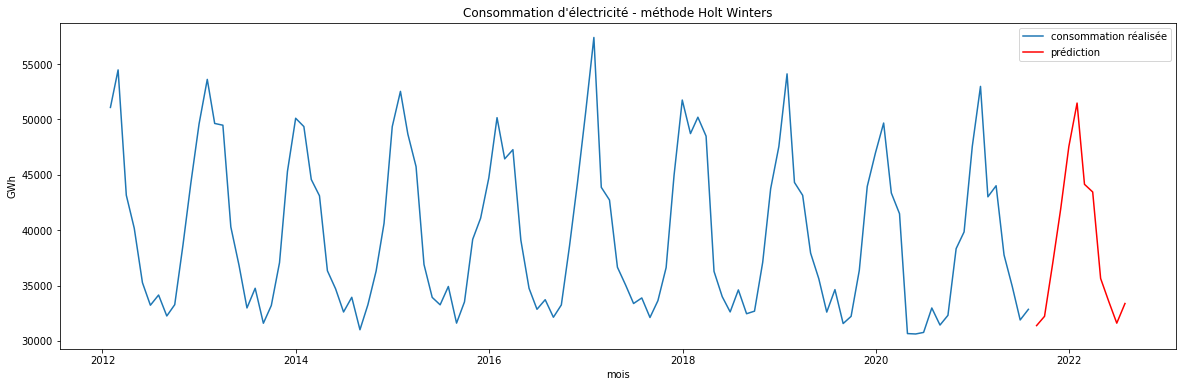

In [13]:
# Sur l'échantillon complet

horizon_prevision_hw=12
periode_prevision_hw=pd.date_range(convertir_fin_de_mois(str(conso_elec2.index[len(conso_elec2)-1]+dt.timedelta(days=1))[0:7]), 
                                   periods=horizon_prevision_hw, freq='M')

hw = ExponentialSmoothing(np.asarray(conso_elec2.conso_totale), seasonal_periods=12, 
                          trend='add', seasonal='add').fit()
hw_prediction_conso_corrigee_dju = hw.forecast(horizon_prevision_hw)

plt.figure(figsize=(20,6))
plt.plot(conso_elec2.conso_totale, label='consommation réalisée')
plt.plot(periode_prevision_hw, hw_prediction_conso_corrigee_dju, label='prédiction',color='r')
plt.title("Consommation d'électricité - méthode Holt Winters")
plt.xlabel('mois')
plt.ylabel('GWh')
plt.legend()
plt.show()